In [200]:
%matplotlib inline
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
with open('processed.csv', 'rb') as f:
    reader = csv.reader(f)
    first = True
    columns = []
    values = []
    dates = []
    for row in reader:
        if first:
            first = False
            columns = row[1:-3] + [row[-3]]
        else:
            dates.append(datetime.datetime.strptime(row[0], '%Y/%m/%d'))
            values.append(map(lambda x: float(x) or np.nan, row[1:-3] + [row[-3]]))

df = pd.DataFrame(values, index=dates, columns=columns).sort_index()         
df_ = pd.DataFrame(values, index=dates, columns=columns).sort_index()
companies = list(columns)
freqs = [3, 7, 15, 30]
for col in df_:
    if col in ('Day',):
        continue
    
    c = df_[col]
    cs = df_[col].shift(1)
    inc_col = '%s_Direction' % col
    df_[inc_col] = np.sign(df_[col] - df_[col].shift(1))
    df_[inc_col].fillna(inplace=True, value=0)
    df_['%s_Lag_%d' % (inc_col, 1)] = df_[inc_col].shift(1)
    for freq in freqs:
        rm_col = '%s_RollM_%d' % (col, freq)
        rstd_col = '%s_RollStd_%d' % (col, freq)
        rmax_col = '%s_RollMax_%d' % (col, freq)
        rmin_col = '%s_RollMin_%d' % (col, freq)
        rvar_col = '%s_RollVar_%d' % (col, freq)
        rsum_col = '%s_RollSum_%d' % (col, freq)
        pchange_col = '%s_PChange_%d' % (col, freq)
        ewma_col = '%s_EWMA_%d' % (col, freq)
        mp = freq < 10 and freq or 10

        df_[pchange_col] = df_[col].pct_change(periods=freq)
        df_[rsum_col] = pd.rolling_sum(cs, freq, min_periods=mp)
        df_[rvar_col] = pd.rolling_var(cs, freq, min_periods=mp)
        df_[rmin_col] = pd.rolling_min(cs, freq, min_periods=mp)
        df_[rmax_col] = pd.rolling_max(cs, freq, min_periods=mp)
        df_[rstd_col] = pd.rolling_std(cs, freq, min_periods=mp)
        df_[rm_col] = pd.rolling_mean(cs, freq, min_periods=mp)
        df_[ewma_col] = pd.ewma(cs, span=freq)
    for i in xrange(1, 30, 5):
        df_['%s_Lag%d' % (col, i)] = df_[col].shift(i)


The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


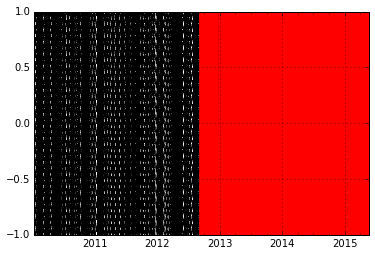

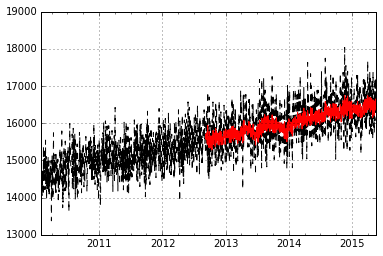

,Company,FSEstimator,Mean Sq Err,Score,Std Err,Vars
0,NBUW,"RFECV(cv=None,\n estimator=LogisticRegressio...",1.100508,0.724873,0.999995,NaN
1,NBUW,"RFECV(cv=None,\n estimator=Ridge(alpha=10, c...",154635.139932,0.528379,572.608101,NaN


In [201]:
def get_independent_values(symbol, df=df_):
    return filter(lambda x: x.startswith(symbol + '_') or x == symbol, df_.columns)

def prepare_df(df, input_cols, output_col, drop_cols=[]):
    import pandas as pd
    df = df_[list(set(list(input_cols) + [output_col]))].dropna()
    
    X = df.drop([output_col] + list(drop_cols), axis=1)
    y = df[output_col]
    return X, y
               
def split_for_train(X, y, sd, ed):
    start_test = ed - (ed - sd) / 2
    X_train = X[X.index < start_test]
    X_test = X[X.index >= start_test]
    y_train = y[y.index < start_test]
    y_test = y[y.index >= start_test]  
    return X_train, y_train, X_test, y_test
    

def try_models(X_train, y_train, X_test, y_test, fs=None):
    import pandas as pd
    import sklearn
    import itertools
    from sklearn.grid_search import GridSearchCV
    from sklearn.qda import QDA
    from sklearn.pipeline import Pipeline
    from math import factorial
    
    fs.fit(X_train, y_train)

    pred = pd.DataFrame({
            'Actual': y_test,
            'Predicted': fs.predict(X_test)
        }, index=y_test.index)
    
    pred['Variance'] = (pred["Actual"] - pred["Predicted"])
    pred['Error'] = pred['Variance'] ** 2

    res = {
        'Company': company,
        'FSEstimator': fs,
        'Mean Sq Err': np.mean(pred['Error']),
        'Std Err': np.std(pred['Actual']),
        'Score': fs.score(X_test, y_test),
        'Vars': (fs.get_params()),
    }

    res_df = pd.DataFrame(res, index=[0])
    y_train.plot(style='k--')
    pred['Actual'].plot(style='k--')
    pred['Predicted'].plot(color='red')
    plt.show()
    return res_df
#     for res in r[:10]:
#         print 'Company %s' % res[1][0]
#         print 'Prediction Model: %s' % res[1][1]
#         print 'Predicted Mean Square of Errors: %f' % res[1][2]
#         print 'Standard Error: %f' % res[1][3]
#         print 'Score %f' % res[1][4]
#         print 'Independent Variables: %s' % res[1][5]
# #     #     print 'Accuracy %0.2f (+/- %0.2f)' % accuracy
# # #         print 'Coefficients %s' % (fs.estimator_.coef_,)

        

results = []
from sklearn import cross_validation, feature_selection, linear_model
for company in companies[:1]:
    sd = datetime.datetime(2010, 1, 1)
    ed = datetime.datetime(2015, 5, 15)
    d1 = df_[sd:ed]
    X, y = prepare_df(
            d1, 
            input_cols=['%s_Lag1' % company, '%s_EWMA_7' % company, '%s_RollSum_15' % company],
            output_col='%s_Direction' % company
        )
    data1 = split_for_train(X, y, sd, ed) 
    dir_model = try_models(*data1, fs=feature_selection.RFECV(linear_model.LogisticRegression()))
    predicted_dir = dir_model['FSEstimator'][0].predict(X)
    X['%s_Estimated_Direction' % company] = predicted_dir
    results.append(dir_model)
    data2 =  split_for_train(*list(prepare_df(
                d1,
                input_cols=get_independent_values(company, X) + get_independent_values('Total', X),
                output_col=company,
                drop_cols=['%s_Direction' % company, 'Total_Direction']
            )) + [sd, ed])
    results.append(try_models(*data2,
                   fs=feature_selection.RFECV(linear_model.Ridge(alpha=10), 1)))
    
final = pd.concat(results, ignore_index=True)
final

,Coef
PFBO,0.911157


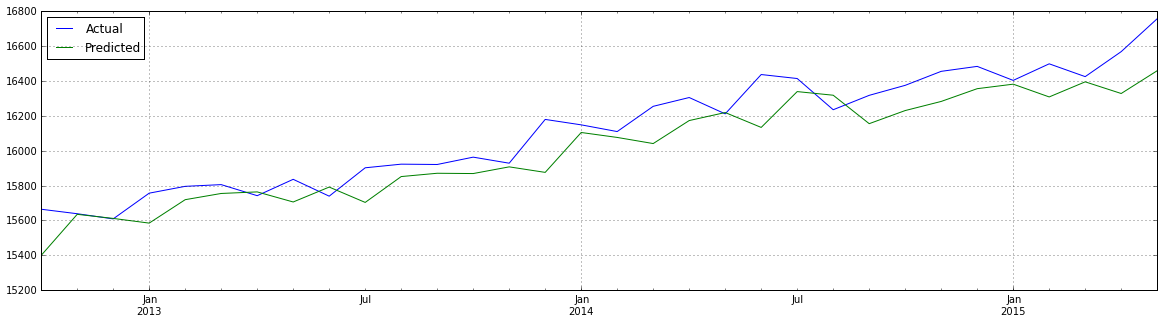

In [227]:
from datetime import datetime, timedelta
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split as tts

epoch = datetime.utcfromtimestamp(0)
cc = {}
for company in companies[:1]:
    company = 'PFBO'
    means = df_[company]
    
    periods = pd.Series(map(lambda x: x.days, np.array(means.index.to_pydatetime()) - epoch))
    df = pd.DataFrame(zip(means, periods),
                      index=means.index, 
                      columns=['Mean', 'Period']).resample('1M', how='mean')
    m = Ridge(alpha=.5)
    df['MeanLag1'] = df['Mean'].shift(1)    
    df['MeanLag2'] = df['Mean'].shift(1) 

    df1 = df[['Mean', 'MeanLag1', 'MeanLag2']].dropna()
    X = df1[['MeanLag1']]
    y = df1['Mean']
    X_train, y_train, X_test, y_test = split_for_train(X, y, X.index[0], y.index[-1])
    m.fit(X_train, y_train)
    rdf = pd.DataFrame({'Actual': y_test, 'Predicted': m.predict(X_test)},index=y_test.index)
    cc[company] = m.coef_[0]
    rdf.plot(figsize=(20,5))

import json
with open('coefs.json', 'w') as f:
    f.write(json.dumps(cc))
    

pd.DataFrame(cc,index=['Coef']).T